In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots

import Base: show

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1260
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


In [2]:
function vmp(n, iters, data)
    model = Model(DefaultMessageGate())
    
    meanv = add!(model, priorvar(:mean, NormalMeanPrecision{Float64}))
    precv = add!(model, priorvar(:precision, GammaAB{Float64}))

    gmpnode = add!(model, GaussianMeanPrecisionNode(factorisation = ( (1,) , (2,) , (3,) )))

    connect!(gmpnode, :mean, meanv, 1)
    connect!(gmpnode, :precision, precv, 1)

    y = add!(model, datavar(:y, Float64))

    connect!(gmpnode, :value, y, 1)

    activate!(model, gmpnode)

    currentmeanv = Ref(NormalMeanPrecision(0.0, 0.00001))
    currentprecv = Ref(GammaAB(0.1, 0.1))
    
    setmarginal!(gmpnode, :mean, currentmeanv[])
    setmarginal!(gmpnode, :precision, currentprecv[])

    subscribe!(getmarginal(meanv), (d) -> currentmeanv[] = getdata(d))
    subscribe!(getmarginal(precv), (d) -> currentprecv[] = getdata(d))

    averageE = combineLatest(
        getmarginal(meanv), getmarginal(precv), getmarginal(y), 
        strategy = PushNew()
    ) |> map(Float64, (marginals) -> averageEnergy(NormalMeanPrecision, marginals)) 

    differentialE = combineLatest(
        getmarginal(meanv), getmarginal(precv), 
        strategy = PushNew()
    ) |> map(Float64, (marginals) -> reduce(+, map(differentialEntropy, marginals)))

    fe = Matrix{Float64}(undef, n, iters)
    ma = Vector{Float64}(undef, n)
    pa = Vector{Float64}(undef, n)

    for i in 1:n
        tmp1 = currentmeanv[]
        tmp2 = currentprecv[]

        averageGamma = combineLatest(
            of(as_marginal(tmp2.a)), of(as_marginal(tmp2.b)), getmarginal(precv),
            strategy = PushNew()
        ) |> map(Float64, (d) -> averageEnergy(GammaAB, d))

        averageNormal = combineLatest(
            of(as_marginal(tmp1.mean)), of(as_marginal(tmp1.precision)), getmarginal(meanv),
            strategy = PushNew()
        ) |> map(Float64, (d) -> averageEnergy(NormalMeanPrecision, d))

        freeEnergy = combineLatest(
            averageE, averageGamma, averageNormal, differentialE,
            strategy = PushNew()
        ) |> map(Float64, (d) -> d[1] + d[2] + d[3] - d[4])

        for j in 1:iters
            subscription = subscribe!(freeEnergy, (d) -> fe[i, j] = d)
            update!(y, data[i])
            unsubscribe!(subscription)
        end

        ma[i] = mean(currentmeanv[])
        pa[i] = mean(currentprecv[])

        update!(meanv, currentmeanv[])
        update!(precv, currentprecv[])
    end
    
    return fe, ma, pa
end

vmp (generic function with 1 method)

In [3]:
realprecision = 0.1999
realmean = -200.0
n = 500
iters = 40

data = rand(Normal(realmean, sqrt(1.0 / realprecision)), (n, ));

In [6]:
@time fe, ma, pa = vmp(n, iters, data);

  0.739262 seconds (6.06 M allocations: 222.314 MiB, 5.72% gc time)


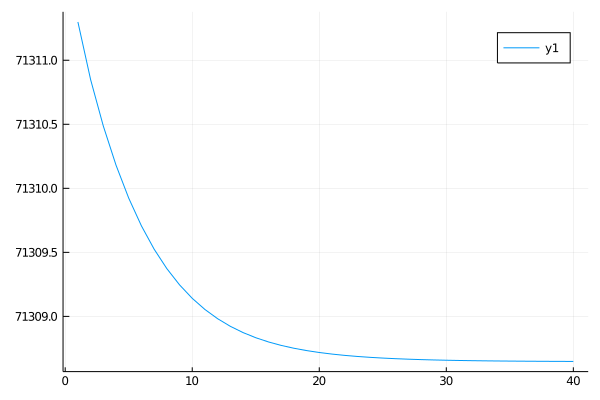

In [7]:
fevalues = vec(sum(fe, dims = 1))
plot(fevalues)

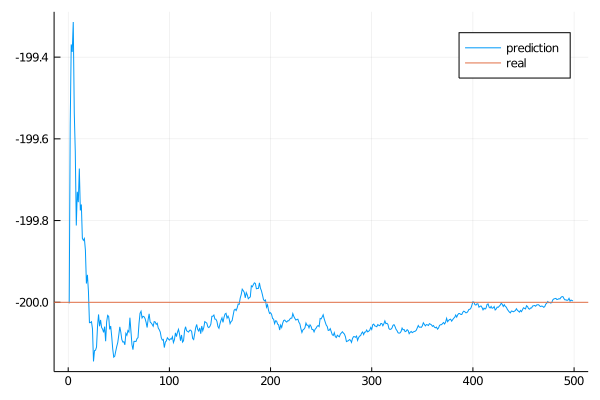

In [8]:
plot(ma[2:end], label = :prediction)
plot!([ realmean ], seriestype=:hline, label = :real)

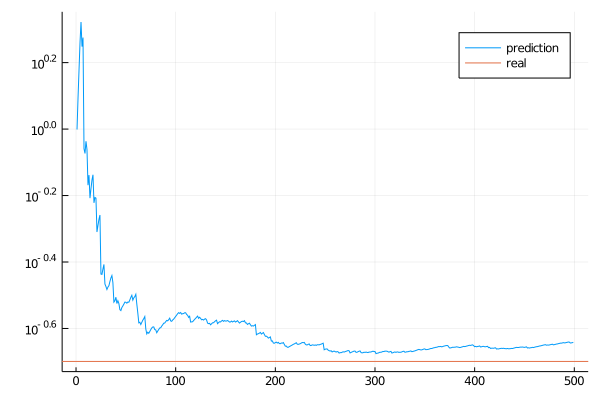

In [9]:
plot(pa[2:end], label = :prediction, yscale = :log10)
plot!([ realprecision ], seriestype=:hline, label = :real)